In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

In [4]:
df = pd.read_csv('../input/support-x5-upd/Vopros_otvet.csv', index_col=0)

In [7]:
df['category'] = df['category'].replace({'Отпуск': 'отпуск'})

In [8]:
df['category'].nunique()

31

In [9]:
df[df['category'] == 'оператор']

,question,content,category
Unnamed: 0,,,
1652,уйди,Для оформления обращения в техническую поддерж...,оператор
1652,оператор,Для оформления обращения в техническую поддерж...,оператор
1652,нужен оператор,Для оформления обращения в техническую поддерж...,оператор
1654,номер телефона службы поддержки,Для оформления обращения в техническую поддерж...,оператор
1688,в какую службу поддержки обратиться по личному...,Для оформления обращения в техническую поддерж...,оператор


In [10]:
# df[df['category'] == 'оператор']

In [11]:
df.loc[1688]['content'], df.loc[1706]['content']

('Для оформления обращения в техническую поддержку вам необходимо нажать на кнопку "Выйти из чата" или позвонить по номеру доб.10-100, прямой +7 (XXX) XXX XX XX.',
 'Для оформления обращения в техническую поддержку вам необходимо нажать на кнопку "Выйти из чата" или позвонить по номеру доб.10-100, прямой +7 (XXX) XXX XX XX.')

In [12]:
df['category'].value_counts()

category
ЛК                     481
поддержка              276
табель                 168
отпуск                 120
удаленная работа        98
увольнение              60
моя карьера             56
БиР                     50
отгул                   48
прием на работу         48
заявки                  47
зарплата                45
ЭЦП                     33
график работы           28
документооборот         22
больничный              17
налоговый вычет         12
уход за больным          9
справка                  9
автомобиль               8
материальная помощь      8
доверенность             7
обучение                 7
оператор                 5
командировка             5
дмс                      3
перевод                  2
МЧД                      1
СБ                       1
SED                      1
выручай-карта            1
Name: count, dtype: int64

In [13]:
df['category'] = df['category'].str.lower()
df['question'] = df['question'].str.lower()
df['content'] = df['content'].str.lower()


df['category'] = df['category'].replace({'лк': 'личный кабинет', 
                                         'бир': 'беременность и роды',
                                         'зп': 'заработная плата',
                                         'ндфл': 'налог на доходы физических лиц',
                                         'тк': 'трудовой договор',
                                         'ао': 'авансовый отчет',
                                         'sla': 'сроки',
                                         'эцп': 'электронная цифровая подпись',
                                         'кр': 'кадровый резерв',
                                        })

df['question'] = df['question'].replace({'лк': 'личный кабинет', 
                                         'бир': 'беременность и роды',
                                         'зп': 'заработная плата',
                                         'ндфл': 'налог на доходы физических лиц',
                                         'тк': 'трудовой договор',
                                         'ао': 'авансовый отчет',
                                         'sla': 'сроки',
                                         'эцп': 'электронная цифровая подпись',
                                         'кр': 'кадровый резерв',
                                        })

df['content'] = df['content'].replace({'лк': 'личный кабинет', 
                                         'бир': 'беременность и роды',
                                         'зп': 'заработная плата',
                                         'ндфл': 'налог на доходы физических лиц',
                                         'тк': 'трудовой договор',
                                         'ао': 'авансовый отчет',
                                         'sla': 'сроки',
                                         'эцп': 'электронная цифровая подпись',
                                         'кр': 'кадровый резерв',
                                        })


# TODO:
0. дефолт acc = 0.71
1. заменить в категориях сокращения
2. все привести к нижнему регистру
3. заменить в контенте сокращения

In [14]:
df.groupby('category')['content'].nunique().sort_values(ascending=False)

category
отпуск                          39
личный кабинет                  27
беременность и роды             22
прием на работу                 19
увольнение                      16
зарплата                        13
электронная цифровая подпись    12
удаленная работа                11
больничный                       9
документооборот                  9
поддержка                        8
заявки                           8
отгул                            7
материальная помощь              6
график работы                    5
доверенность                     5
табель                           4
налоговый вычет                  3
справка                          3
дмс                              3
моя карьера                      3
оператор                         2
выручай-карта                    1
командировка                     1
sed                              1
автомобиль                       1
мчд                              1
перевод                          1
обучение   

In [15]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
# print(f"Using device: {device}")

In [16]:
# Объединение категорий "поддержка" и "оператор" в "оператор"
df['category'] = df['category'].replace({'оператор': 'поддержка'})

In [17]:
category_counts = df['category'].value_counts()
small_categories = category_counts[category_counts < 7].index
df['category'] = df['category'].replace(small_categories, 'поддержка')

In [19]:
df['category'].value_counts()

category
личный кабинет                  481
поддержка                       295
табель                          168
отпуск                          120
удаленная работа                 98
увольнение                       60
моя карьера                      56
беременность и роды              50
отгул                            48
прием на работу                  48
заявки                           47
зарплата                         45
электронная цифровая подпись     33
график работы                    28
документооборот                  22
больничный                       17
налоговый вычет                  12
уход за больным                   9
справка                           9
материальная помощь               8
автомобиль                        8
доверенность                      7
обучение                          7
Name: count, dtype: int64

In [21]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['category'], random_state=42)

In [22]:
model_name = 'sberbank-ai/sbert_large_nlu_ru'
model_name = 'deepvk/USER-bge-m3'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# 4. Функция для получения эмбеддингов
def embed_text(text_list):
    inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt", max_length=128)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Перемещаем данные на GPU
    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state[:, 0, :]  # Используем только [CLS] токен
    return embeddings.cpu().numpy()  # Возвращаем на CPU для дальнейшей работы с numpy

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.33M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/697 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

In [23]:
X_train_embeddings = embed_text(train_df['question'].tolist())
X_test_embeddings = embed_text(test_df['question'].tolist())

In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train_df['category'])
y_test = le.transform(test_df['category'])

In [25]:
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_embeddings, y_train)

LogisticRegression(max_iter=1000)

In [26]:
y_pred = classifier.predict(X_test_embeddings)
print(classification_report(y_test, y_pred, target_names=le.classes_))

                              precision    recall  f1-score   support

                  автомобиль       1.00      1.00      1.00         2
         беременность и роды       1.00      1.00      1.00        10
                  больничный       0.50      0.33      0.40         3
               график работы       0.75      1.00      0.86         6
                доверенность       0.50      1.00      0.67         1
             документооборот       0.00      0.00      0.00         4
                    зарплата       0.80      0.89      0.84         9
                      заявки       0.89      0.89      0.89         9
              личный кабинет       0.83      0.86      0.85        96
         материальная помощь       1.00      1.00      1.00         2
                 моя карьера       0.86      0.55      0.67        11
             налоговый вычет       1.00      1.00      1.00         2
                    обучение       1.00      1.00      1.00         1
                   

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8125


In [96]:
# y_test

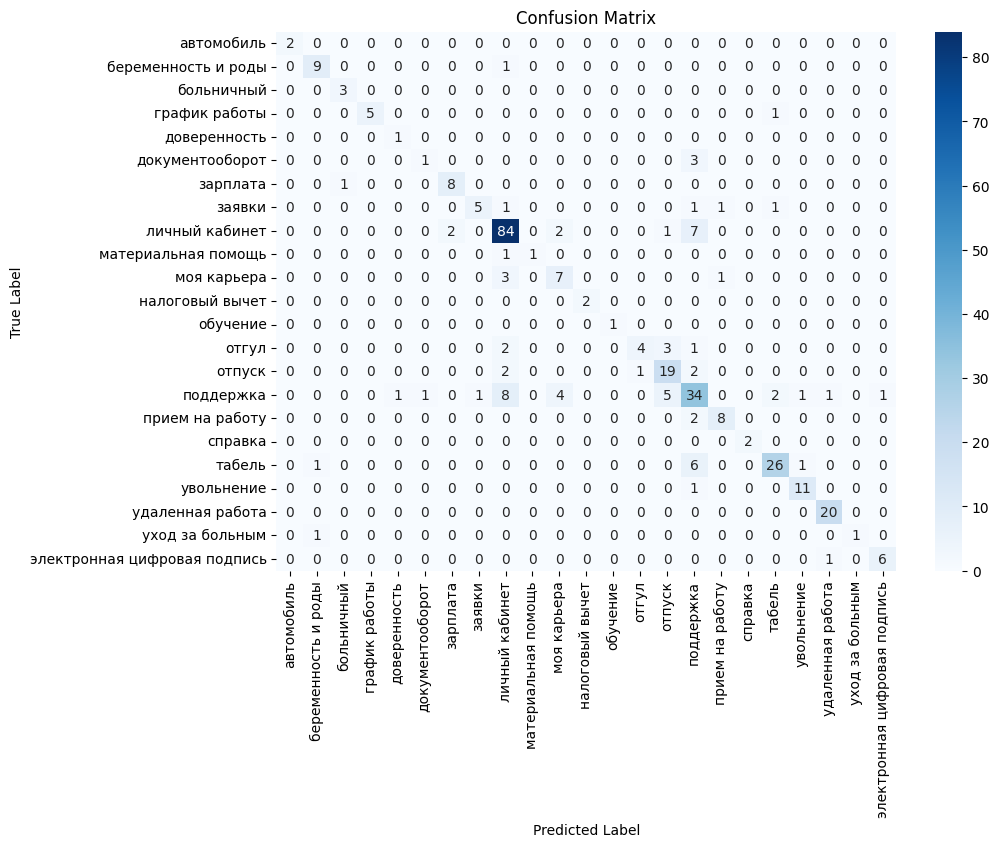

In [25]:
# # 10. Построение матрицы ошибок
# conf_matrix = confusion_matrix(y_test, y_pred)

# # 11. Визуализация матрицы ошибок
# plt.figure(figsize=(10, 7))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()

In [29]:
df

,question,content,category
Unnamed: 0,,,
0,"я сменил автомобить, на учет еще не поставил, ...",для внесения данных по личному автомобилю обра...,автомобиль
1,не отображается автомобиль в личном кабинете.,для внесения данных по личному автомобилю обра...,автомобиль
2,добавить автомобиль,для внесения данных по личному автомобилю обра...,автомобиль
3,хочу внести данные об автомобиле,для внесения данных по личному автомобилю обра...,автомобиль
4,как внести данные об автомобиле?,для внесения данных по личному автомобилю обра...,автомобиль
...,...,...,...
1702,ошибка 500,данная ошибка возможна при переходе на портал\...,обучение
1703,при входе на портал обучения выходит ошибка 505,данная ошибка возможна при переходе на портал\...,обучение
1704,привязать другой номер к карте лояльности,для изменения привязанного номера к карте лоял...,личный кабинет


In [31]:
!pip install gigachain-community
!pip install gigachain
!pip install gigachat

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 54.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.0/402.0 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.3/289.3 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.9/211.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.2 requires cubinlinker, which is not installed.
cudf 24.8.2 requires cupy-cuda11x>=12.0.0, whic

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [36]:
df

,question,content,category
Unnamed: 0,,,
0,"я сменил автомобить, на учет еще не поставил, ...",для внесения данных по личному автомобилю обра...,автомобиль
1,не отображается автомобиль в личном кабинете.,для внесения данных по личному автомобилю обра...,автомобиль
2,добавить автомобиль,для внесения данных по личному автомобилю обра...,автомобиль
3,хочу внести данные об автомобиле,для внесения данных по личному автомобилю обра...,автомобиль
4,как внести данные об автомобиле?,для внесения данных по личному автомобилю обра...,автомобиль
...,...,...,...
1702,ошибка 500,данная ошибка возможна при переходе на портал\...,обучение
1703,при входе на портал обучения выходит ошибка 505,данная ошибка возможна при переходе на портал\...,обучение
1704,привязать другой номер к карте лояльности,для изменения привязанного номера к карте лоял...,личный кабинет


In [32]:
"""Пример работы с чатом через gigachain"""
from langchain.schema import HumanMessage, SystemMessage
from langchain.chat_models.gigachat import GigaChat

In [41]:
def generate_prompt_for_category(category, df):
    category_responses = df[df["category"] == category]["content"].unique()
    
    prompt = ""
    for i, response in enumerate(category_responses, 1):
        prompt += f"{i}. {response}\n"
    
    return prompt, category_responses

In [63]:
def send_to_gigachat(user_query, category, df):
    
    chat = GigaChat(credentials='<token>', verify_ssl_certs=False)
    
    prompt_prefix = f'Дан вопрос: {user_query}\nПожалуйста, укажи номер наиболее релевантного ответа на этот вопрос:\n'
    categories_prompt, category_responses = generate_prompt_for_category(category, df)
    prompt_suffix = 'В качестве ответа укажи только номер.'
    prompt = prompt_prefix + categories_prompt + prompt_suffix
    print(prompt)
    
    messages = [
        SystemMessage(content="Ты бот, который помогает автоматизировать поддержку."),
        HumanMessage(content=f"{prompt}")
    ]
    
    response = chat(messages)
    
    selected_number = int(response.content.strip())
    original_response = category_responses[selected_number - 1]
    
    return original_response

# Пример использования
category = "автомобиль"
user_query = "не отображается автомобиль в личном кабинете."
response = send_to_gigachat(user_query, category, df)
print(response)

Дан вопрос: не отображается автомобиль в личном кабинете.
Пожалуйста, укажи номер наиболее релевантного ответа на этот вопрос:
1. для внесения данных по личному автомобилю обратитесь, пожалуйста, к своему руководителю для создания заявки по теме "изменение режима характера работы", подтема "установка рхр и топливной карты". в комментариях опишите ситуацию и приложите птс, стс, страховой полис и водительское удостоверение.
В качестве ответа укажи только номер.
для внесения данных по личному автомобилю обратитесь, пожалуйста, к своему руководителю для создания заявки по теме "изменение режима характера работы", подтема "установка рхр и топливной карты". в комментариях опишите ситуацию и приложите птс, стс, страховой полис и водительское удостоверение.


In [64]:
def predict(query):
    query_embedding = embed_text([query])
    
    predicted_label = classifier.predict(query_embedding)
    
    predicted_categories = le.inverse_transform(predicted_label)
    
    predicted_category = predicted_categories[0]  # Поскольку это массив, возвращаем первый элемент
    print('Категория: ', predicted_category)
    answer = send_to_gigachat(query, predicted_category, df)
    print('Ответ на вопрос', answer)
    return answer

In [68]:
predicted_category = predict("Мне нужен оператор")

Категория:  поддержка
Дан вопрос: Мне нужен оператор
Пожалуйста, укажи номер наиболее релевантного ответа на этот вопрос:
1. в рамках нового сервисного подхода сотрудники оформляют командировку на едином портале trip.
2. информацию о своих действующих мчд (машиночитаемых доверенностях) можно найти в личном кабинете https://company-x5.ru/ - раздел «доверенности». данный раздел можно найти в правом верхнем углу, в выпадающем списке под своими фио. инструкция доступна по ссылке https://company-x5.ru/cms/uc9
3. создайте заявку по теме "перевод" в списке заявок в лк.
4. создайте, пожалуйста, обращение в ит поддержку на портале support
5. по данному вопросу вы можете обратиться в кадровую службу, создав заявку "консультация по hr вопросам"
6. просьба очистить кеш/куки с использованием клавиш ctrl + shift + delete. при появлении окошка с настройками в разделе "за период" выбрать "за все время". далее выйти с личного кабинета с использованием клавиши "выход" и авторизоваться повторно введя лог

In [69]:
predict('не отображается автомобиль в личном кабинете.')

Категория:  автомобиль
Дан вопрос: не отображается автомобиль в личном кабинете.
Пожалуйста, укажи номер наиболее релевантного ответа на этот вопрос:
1. для внесения данных по личному автомобилю обратитесь, пожалуйста, к своему руководителю для создания заявки по теме "изменение режима характера работы", подтема "установка рхр и топливной карты". в комментариях опишите ситуацию и приложите птс, стс, страховой полис и водительское удостоверение.
В качестве ответа укажи только номер.
Ответ на вопрос для внесения данных по личному автомобилю обратитесь, пожалуйста, к своему руководителю для создания заявки по теме "изменение режима характера работы", подтема "установка рхр и топливной карты". в комментариях опишите ситуацию и приложите птс, стс, страховой полис и водительское удостоверение.


'для внесения данных по личному автомобилю обратитесь, пожалуйста, к своему руководителю для создания заявки по теме "изменение режима характера работы", подтема "установка рхр и топливной карты". в комментариях опишите ситуацию и приложите птс, стс, страховой полис и водительское удостоверение.'